In [1]:
#import matplotlib, numpy, os, tensorflow

import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [2]:
# download the dataset
url = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=url, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

# set train_dir and validationdir
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

#set BATCH_SIZE and IMAGE_SIZE
BATCH_SIZE = 100
IMAGE_SIZE = 150

# train_dataset
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(train_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=(IMAGE_SIZE, IMAGE_SIZE))


Found 2000 files belonging to 2 classes.


In [3]:
# validation_dataset
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(validation_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=(IMAGE_SIZE, IMAGE_SIZE))


Found 1000 files belonging to 2 classes.


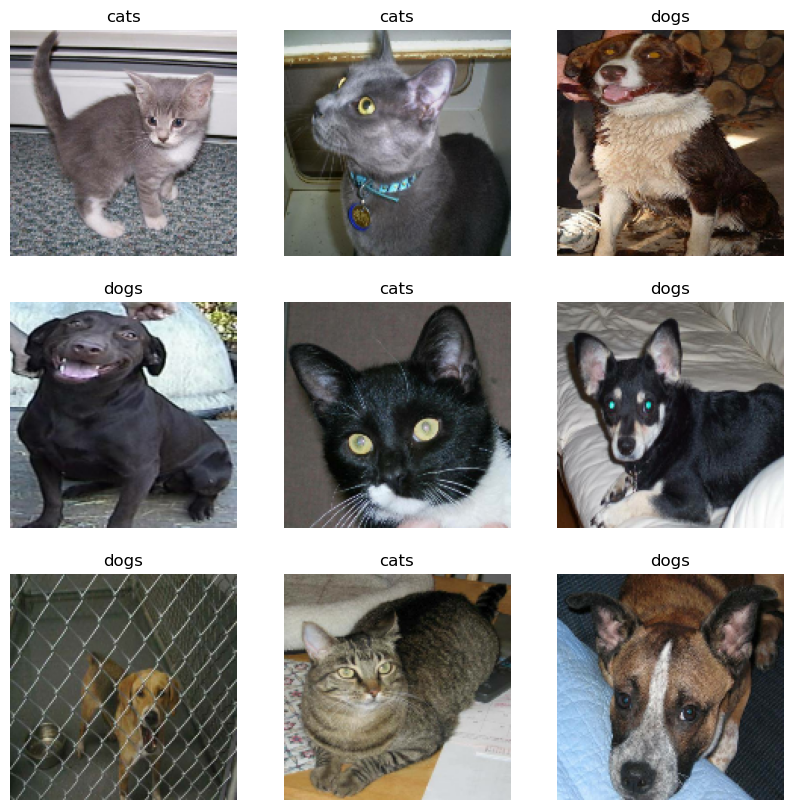

In [4]:
#show first nine images and labels from training set
class_names = train_dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
        


In [5]:
# move 20% of cardinality to test set
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)
# print number of test and validation batches
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))


Number of validation batches: 8
Number of test batches: 2


In [6]:
#autotune dataset for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


In [7]:
#augment the dataset
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])


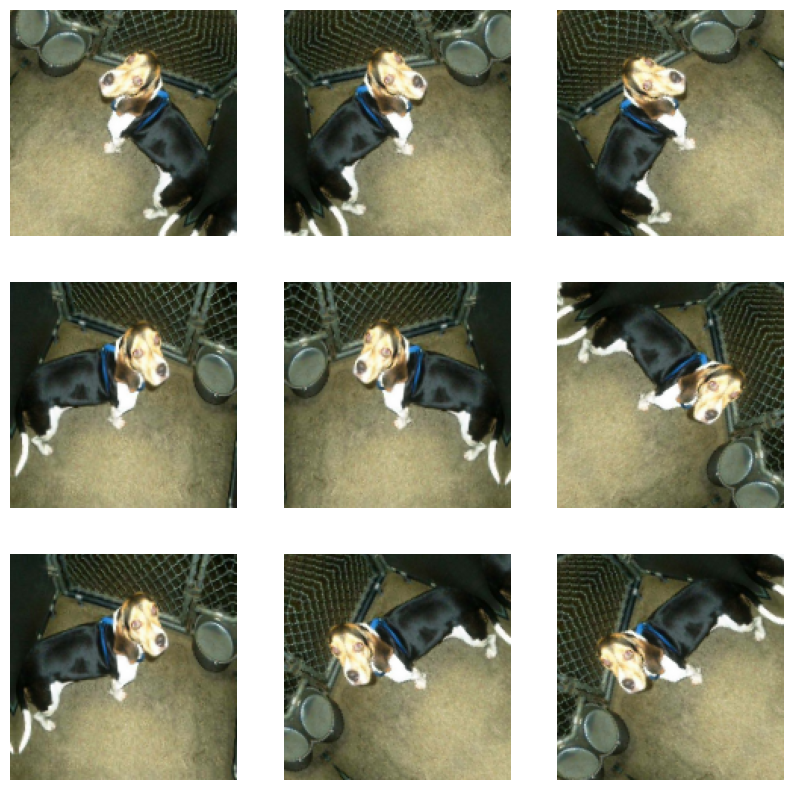

In [8]:
#apply layers repeatedly to same image and see result
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')
        
        

In [9]:
#rescale pixel values
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
#use keras rescaling
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)


In [10]:
#create base model from pre-trained convnets
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')


In [11]:
#apply to sameple batch of images
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)


(100, 5, 5, 1280)


In [12]:
#freeze convolutional base
base_model.trainable = False


In [13]:
#print base_model summary
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 75, 75, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 75, 75, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 75, 75, 32)           0         ['bn_Conv1[

In [14]:
#convert features to single vector
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)


(100, 1280)


In [15]:
#convert features into single prediction per image
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)


(100, 1)


In [16]:
#build model chaining previous layers
inputs = tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)
#print model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 150, 150, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 150, 150, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                             

In [17]:
#check length of model training variables
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 2


In [18]:
#install pydot and graphviz
# %pip install pydot
# %pip install graphviz


In [19]:
#plot model
#tf.keras.utils.plot_model(model, show_shapes=True)


In [20]:
#compile the model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])


In [21]:
#train the model    
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))
history = model.fit(train_dataset, epochs=initial_epochs, validation_data=validation_dataset)


8/8 [==============================] - 5s 464ms/step - loss: 0.9433 - accuracy: 0.4275
initial loss: 0.94
initial accuracy: 0.43
Epoch 1/10
20/20 [==============================] - 20s 826ms/step - loss: 0.5607 - accuracy: 0.7110 - val_loss: 0.1792 - val_accuracy: 0.9237
Epoch 2/10
20/20 [==============================] - 18s 883ms/step - loss: 0.2739 - accuracy: 0.8725 - val_loss: 0.1127 - val_accuracy: 0.9475
Epoch 3/10
20/20 [==============================] - 17s 838ms/step - loss: 0.2192 - accuracy: 0.8955 - val_loss: 0.0985 - val_accuracy: 0.9600
Epoch 4/10
20/20 [==============================] - 18s 855ms/step - loss: 0.2005 - accuracy: 0.9135 - val_loss: 0.0940 - val_accuracy: 0.9638
Epoch 5/10
20/20 [==============================] - 18s 881ms/step - loss: 0.1850 - accuracy: 0.9130 - val_loss: 0.0844 - val_accuracy: 0.9700
Epoch 6/10
20/20 [==============================] - 18s 889ms/step - loss: 0.1891 - accuracy: 0.9170 - val_loss: 0.0950 - val_accuracy: 0.9688
Epoch 7/10
20

Text(0.5, 1.0, 'Training and Validation Loss')

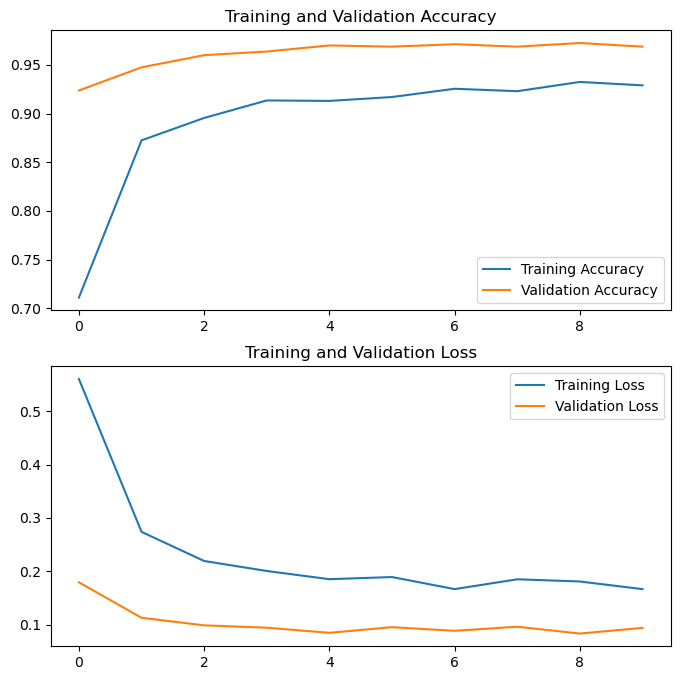

In [22]:
#plot learning curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(initial_epochs)
plt.figure(figsize=(8, 8))
plt.subplot(2,1,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(2,1,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

In [23]:
#unfreeze top layers of the model
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    

Number of layers in the base model:  154


In [24]:
#compile model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate / 10), metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 150, 150, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 150, 150, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                             

In [25]:
#print length of training variables
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))


Number of trainable variables = 56


In [26]:
#continue training the model
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs
history_fine = model.fit(train_dataset, epochs=total_epochs, initial_epoch=history.epoch[-1], validation_data=validation_dataset)


Epoch 10/20
20/20 [==============================] - 28s 1s/step - loss: 2.4999 - accuracy: 0.5170 - val_loss: 0.6965 - val_accuracy: 0.4988
Epoch 11/20
20/20 [==============================] - 24s 1s/step - loss: 0.7855 - accuracy: 0.5125 - val_loss: 0.6986 - val_accuracy: 0.4988
Epoch 12/20
20/20 [==============================] - 25s 1s/step - loss: 0.7847 - accuracy: 0.5100 - val_loss: 0.7124 - val_accuracy: 0.4963
Epoch 13/20
20/20 [==============================] - 25s 1s/step - loss: 0.7895 - accuracy: 0.4995 - val_loss: 0.7088 - val_accuracy: 0.4925
Epoch 14/20
20/20 [==============================] - 24s 1s/step - loss: 0.7588 - accuracy: 0.5065 - val_loss: 0.6963 - val_accuracy: 0.5050
Epoch 15/20
20/20 [==============================] - 24s 1s/step - loss: 0.7732 - accuracy: 0.4870 - val_loss: 0.6983 - val_accuracy: 0.5013
Epoch 16/20
20/20 [==============================] - 24s 1s/step - loss: 0.7558 - accuracy: 0.4935 - val_loss: 0.6984 - val_accuracy: 0.4900
Epoch 17/20
2

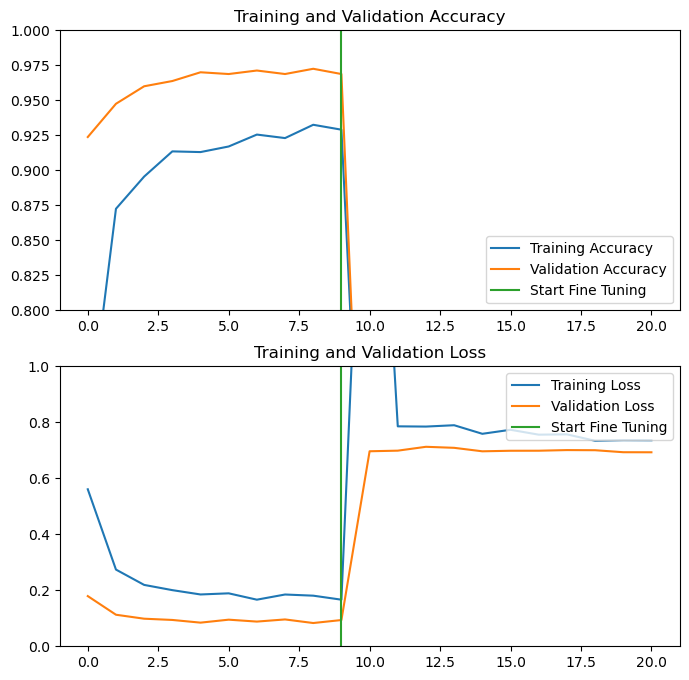

In [27]:
#update accuracies and plot learning curves
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs - 1, initial_epochs - 1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs - 1, initial_epochs - 1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [28]:
#evaluate the model
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

2/2 [==============================] - 1s 501ms/step - loss: 0.6999 - accuracy: 0.5750
Test accuracy : 0.574999988079071


In [29]:
#use model to predict on new data
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)
print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)


Predictions:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Labels:
 [0 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1 1 0 0 0 1 1 0 0 0 1 0 1 1 1 1 0 0 1 0 1
 0 0 1 1 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 1 0 0 0 1 1 0
 1 1 1 1 1 0 0 0 1 1 0 1 1 1 0 1 1 1 1 1 0 1 0 0 0 0]


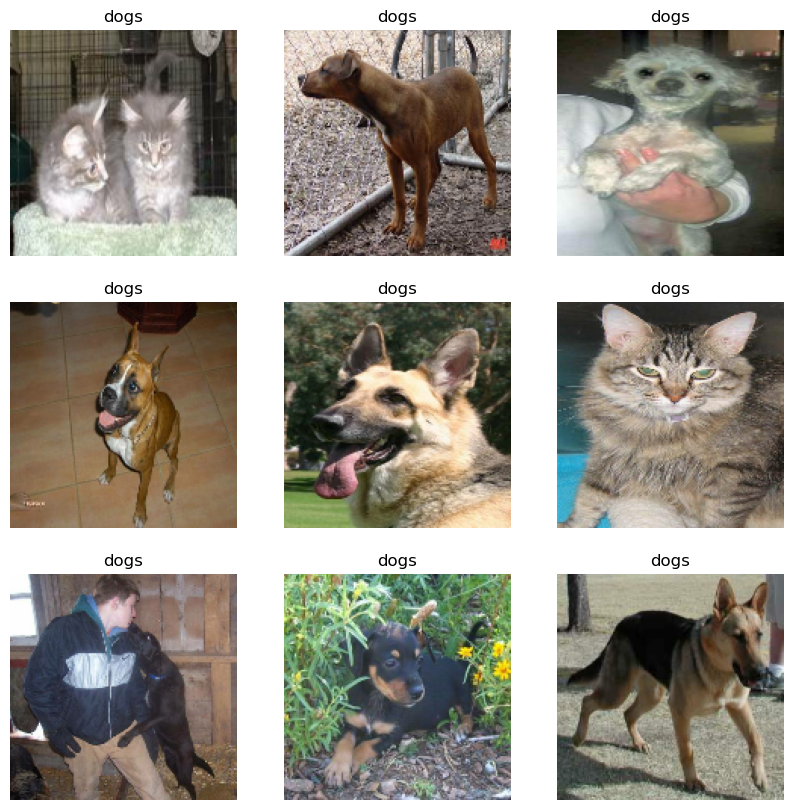

In [30]:
#plot images and predictions
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype('uint8'))
    plt.title(class_names[predictions[i]])
    plt.axis('off')
    